In [80]:
# there no change change in the first several cells from last lecture

In [81]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [82]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [83]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [84]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [85]:
# ok biolerplate done, now we get to the action:

In [86]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [163]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [164]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [165]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3316, grad_fn=<NegBackward0>)

In [199]:
demb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [200]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n # -0.03125 with batch size of 32

dprobs = (1 / probs) * dlogprobs

# must use sum + keepdim=True to backpropogate in a way that respects
# the broadcast duplication of the columns from the original operation:
#
# probs = counts * counts_sum_inv
#
# ^ counts is (32,27) and counts_sum_inv is (32,1) so counts_sum_inv is
# duplicated column wise 27 times
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum **-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum

# instead of re-exponentiating, just reuse counts since
# d(e^x) == e^x
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()

# since we're broadcasting logit_maxes from (32,1) to (32,27), we should
# sum in the derivative case
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

# F.one_hot being used to assign a derivative of 1 to every max logit index plucked
# out in the forward pass
# You can plot what's going on here with:
# plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))
dlogits += dlogit_maxes * F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])

# take a look at your notes for this one, but easy way is to look at shapes:
#
# dlogits.shape, h.shape, W2.shape, b2.shape
# (torch.Size([32, 27]),
#  torch.Size([32, 64]),
#  torch.Size([64, 27]),
#  torch.Size([27]))
#
# you know that dh has to be the same shape as h and that we have to use dlogits
# because of the chain rule. so there's only one way to get (32,64)
dh = dlogits @ W2.T
# apply same shape rule:
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

dhpreact = dh * (1 - h**2)

# broadcasting rules - must sum across the columns to get a
# single column (bngain's shape)
dbngain = (dhpreact * bnraw).sum(0, keepdim=True)

# ^ same on broadcasting
dbnbias = dhpreact.sum(0, keepdim=True)

# should be good here on multiplying - broadcast will do
# the heavy lifting for us:
# (32,64) * (1,64) will multiply the second matrix across all
# columns getting us (32,64) which is bnraw's shape
dbnraw = dhpreact * bngain

dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)
dbndiff = dbnraw * bnvar_inv # we will add to this later
dbnvar = dbnvar_inv * -0.5 * (bnvar + 1e-05)**-1.5
dbndiff2 = ((1.0 / (n - 1)) * torch.ones_like(bndiff2)) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2

dbnmeani = (-dbndiff).sum(0, keepdim=True)
dhprebn = dbndiff.clone()
dhprebn += (torch.ones_like(hprebn) * (1.0 / n)) * dbnmeani

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

# you can just re-view the data back to its original form
# I still don't 100% get this, but intuitively it seems like
# the local gradient of dembcat just flows through via the
# chain rule and no data is being changed, so it should just
# be gradients entirely from dembcat
demb = dembcat.view(emb.shape)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [201]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.331596612930298 diff: 0.0


In [207]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-09


In [208]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [209]:
F.softmax(logits, 1)[0]

tensor([0.0664, 0.0899, 0.0210, 0.0495, 0.0181, 0.0809, 0.0276, 0.0360, 0.0191,
        0.0286, 0.0355, 0.0344, 0.0405, 0.0280, 0.0346, 0.0148, 0.0086, 0.0202,
        0.0152, 0.0587, 0.0502, 0.0213, 0.0260, 0.0684, 0.0587, 0.0254, 0.0222],
       grad_fn=<SelectBackward0>)

In [212]:
dlogits[0] * n

tensor([ 0.0664,  0.0899,  0.0210,  0.0495,  0.0181,  0.0809,  0.0276,  0.0360,
        -0.9809,  0.0286,  0.0355,  0.0344,  0.0405,  0.0280,  0.0346,  0.0148,
         0.0086,  0.0202,  0.0152,  0.0587,  0.0502,  0.0213,  0.0260,  0.0684,
         0.0587,  0.0254,  0.0222], grad_fn=<MulBackward0>)

In [213]:
dlogits[0].sum()

tensor(1.1642e-09, grad_fn=<SumBackward0>)

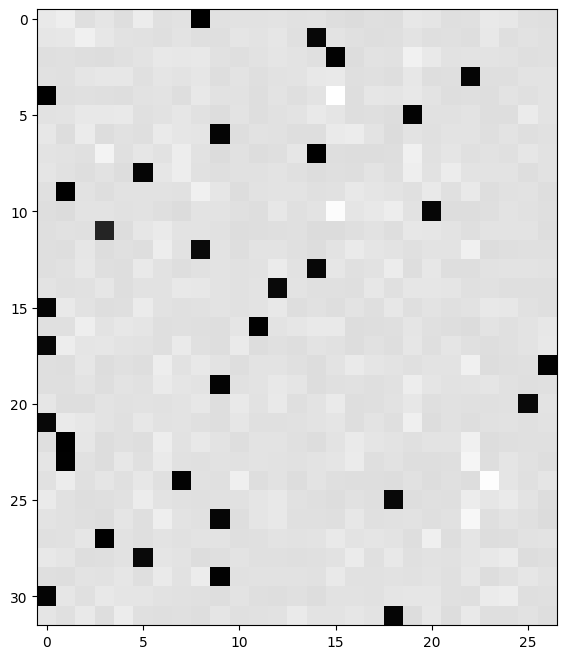

In [211]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now: